
# Implementation of Faster RCNN
On the Pascal VOC dataset

1. We will be training the RPN first and then Fast RCNN later using the region proposals from RPN

In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import pandas as pd
from tqdm import tqdm
import timeit
import time
from skimage import transform, io
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import os
from __future__ import division, print_function
import shutil
%matplotlib inline
import glob
import torchvision.transforms as T
from torchvision import utils
import scipy.misc as m

In [2]:
# Preparing the dataset
train_list = '/Users/navneetmkumar/Documents/Paper Implementations/VOC2007/ImageSets/Layout/train.txt'

def get_images(file):
    train_images = []
    f = open(file, 'r')
    filecontents = f.readlines()
    for line in filecontents:
        img_name = line.strip("\n")
        train_images.append(img_name)
    return train_images

In [3]:
train_images = get_images(train_list)
print(len(train_images))

318


In [4]:
# Get the actual images and create a train_images folder
images_dir = '/Users/navneetmkumar/Documents/Paper Implementations/VOC2007/JPEGImages'

if not os.path.exists('/Users/navneetmkumar/Documents/Paper Implementations/train-inputs'):
    os.makedirs('/Users/navneetmkumar/Documents/Paper Implementations/train-inputs')
    
new_images_dir = '/Users/navneetmkumar/Documents/Paper Implementations/train-inputs'
    
def copyFiles(directory, target_dir):
    for f in os.listdir(directory):
        f_name = os.path.basename(f)
        f_name = f_name.split(".")[0]
        if f_name in train_images:
            f = os.path.join(directory, f)
            shutil.copy2(f, target_dir)

In [5]:
copyFiles(images_dir, new_images_dir)

In [15]:
# Developing the targets
import os
import pandas as pd
from bs4 import BeautifulSoup
import voc_utils
from more_itertools import unique_everseen
root_dir = '/Users/navneetmkumar/Documents/Paper Implementations/VOC2007/'
annotations_dir = '/Users/navneetmkumar/Documents/Paper Implementations/VOC2007/Annotations'
def annotations_from_list(img_name):
    return os.path.join(annotations_dir, img_name)+".xml"

In [19]:
# annotation operations
def load_annotation(img_filename):
    xml = ""
    with open(annotations_from_list(img_filename)) as f:
        xml = f.readlines()
    xml = ''.join([line.strip('\t') for line in xml])
    return BeautifulSoup(xml, "lxml")

In [20]:
# image operations
def load_img(img_filename):
    return io.load_image(os.path.join(new_images_dir, img_filename + '.jpg'))

<html><body><annotation>
<folder>VOC2007</folder>
<filename>000012.jpg</filename>
<source>
<database>The VOC2007 Database</database>
<annotation>PASCAL VOC2007</annotation>
<image>flickr</image>
<flickrid>207539885</flickrid>
</source>
<owner>
<flickrid>KevBow</flickrid>
<name>?</name>
</owner>
<size>
<width>500</width>
<height>333</height>
<depth>3</depth>
</size>
<segmented>0</segmented>
<object>
<name>car</name>
<pose>Rear</pose>
<truncated>0</truncated>
<difficult>0</difficult>
<bndbox>
<xmin>156</xmin>
<ymin>97</ymin>
<xmax>351</xmax>
<ymax>270</ymax>
</bndbox>
</object>
</annotation>
</body></html>


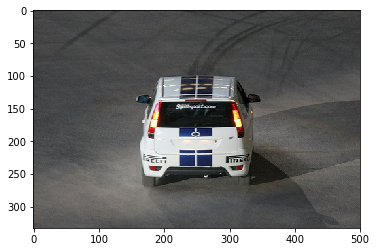

In [21]:
# Test with one image
filename = os.path.join(new_images_dir, train_images[0])+".jpg"
f = io.imread(filename)
plt.imshow(f)
a = load_annotation(train_images[0])
print(a)

In [126]:
# Loading the training data
def load_train_data(train_images_list):
    data = []
    data_dict = {}
    for item in train_images_list:
        anno = load_annotation(item)
        objs = anno.findAll('object')
        for obj in objs:
            obj_names = obj.findChildren('name')
            for name_tag in obj_names:
                bbox = obj.findChildren('bndbox')[0]
                xmin = int(bbox.findChildren('xmin')[0].contents[0])
                ymin = int(bbox.findChildren('ymin')[0].contents[0])
                xmax = int(bbox.findChildren('xmax')[0].contents[0])
                ymax = int(bbox.findChildren('ymax')[0].contents[0])
                cat_name = name_tag.contents[0]
                data.append([item,cat_name, xmin, ymin, xmax, ymax])
                if data_dict.get(item) == None:
                    data_dict[item] = [[cat_name, xmin, ymin, xmax, ymax]]
                else:
                    val = data_dict[item]
                    val.append([cat_name, xmin, ymin, xmax, ymax])
                    data_dict[item] = val
                    
    df = pd.DataFrame(data, columns=['fname','category', 'xmin', 'ymin', 'xmax', 'ymax'])
    return df, data, data_dict

In [127]:
df, data, data_dict = load_train_data(train_images)

Exception ignored in: <bound method DataLoaderIter.__del__ of <torch.utils.data.dataloader.DataLoaderIter object at 0x124b5fa20>>
Traceback (most recent call last):
  File "/Users/navneetmkumar/anaconda/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 241, in __del__
    self._shutdown_workers()
  File "/Users/navneetmkumar/anaconda/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 237, in _shutdown_workers
    self.index_queue.put(None)
  File "/Users/navneetmkumar/anaconda/lib/python3.5/multiprocessing/queues.py", line 355, in put
    self._writer.send_bytes(obj)
  File "/Users/navneetmkumar/anaconda/lib/python3.5/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/navneetmkumar/anaconda/lib/python3.5/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/navneetmkumar/anaconda/lib/python3.5/multiprocessing/connection.py", line 368, in _send


[['tvmonitor', 419, 1, 500, 77],
 ['person', 207, 39, 374, 330],
 ['head', 207, 39, 374, 330],
 ['hand', 207, 39, 374, 330],
 ['foot', 207, 39, 374, 330],
 ['foot', 207, 39, 374, 330],
 ['hand', 207, 39, 374, 330],
 ['person', 104, 84, 369, 374],
 ['head', 104, 84, 369, 374],
 ['hand', 104, 84, 369, 374],
 ['hand', 104, 84, 369, 374],
 ['foot', 104, 84, 369, 374],
 ['foot', 104, 84, 369, 374],
 ['bottle', 373, 88, 386, 130],
 ['bottle', 356, 81, 373, 127]]

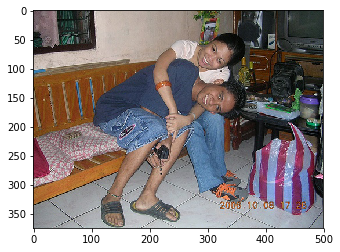

In [132]:
# Test with one image
filename = os.path.join(new_images_dir, train_images[211])+".jpg"
f = io.imread(filename)
plt.imshow(f)
data_dict[train_images[211]]

In [121]:
# Creating the training dataset
class DetectionDataset(Dataset):
    
    def __init__(self, train_images_list, img_size = 512, is_transform=False):
        self.train_images_list = train_images_list
        self.is_transform = is_transform
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        self.n_classes = 21
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)
        
    def __len__(self):
        return len(self.train_images_list)
    
    def __getitem__(self, i):
        train_images_list = self.train_images_list
        filename = os.path.join(new_images_dir, train_images_list[i])+".jpg"
        image = io.imread(filename)
        labels = data_dict[train_images[i]]
        label = []
        for l in labels:
            label.append(l[1:])
        image= np.array(image, dtype=np.uint8)
        label = np.asarray(label, dtype=np.int32)
        sample = {'image': image, 'lbl':label}
        if self.is_transform:
            sample = self.transform(sample)
        return sample
    
    def transform(self, sample):
        img = sample['image']
        lbl = sample['lbl']
        img = img[:, :, ::-1]
        img = img.astype(np.float64)
        img -= self.mean
        img = m.imresize(img, (self.img_size[0], self.img_size[1]))
        # Resize scales images from 0 to 255, thus we need
        # to divide by 255.0
        img = img.astype(float) / 255.0
        # NHWC -> NCWH
        img = img.transpose(2, 0, 1)
        img = torch.from_numpy(img).float()
        lbl = np.array(lbl)
        lbl = torch.from_numpy(lbl).long()
        print(lbl)
        sample  = {'image': img, 'lbl': lbl}
        return sample
        

In [122]:
data = DetectionDataset(train_images, is_transform=True)

In [134]:
# Create the dataloader object
# Instead of using a simple for loop we will be using the torch.utils.DataLoader
# It provides the following features:
# 1.Batching the data
# 2.Shuffling the data
# 3.Load data in parallel using multiprocessing workers

collate_old = torch.utils.data.dataloader.default_collate
torch.utils.data.dataloader.default_collate = lambda batch: batch if all(map(torch.is_tensor, batch)) and any([tensor.size() != batch[0].size() for tensor in batch]) else collate_old(batch)
dataloader = DataLoader(data, batch_size=4, shuffle=True, num_workers=4)

In [ ]:
for i_batch, sample_batched in enumerate(dataloader):
    imgs, labels = sample_batched['image'], sample_batched['lbl']
    if i_batch==0:
        img = torchvision.utils.make_grid(imgs).numpy()
        img = np.transpose(img, (1, 2, 0))
        img = img[:, :, ::-1]
        plt.imshow(img)
        plt.show()  